<a href="https://colab.research.google.com/github/wzummo/Neural-Network-Approximation-of-ODEs/blob/main/dy_dx_%2B_2xy_%3D_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $dy/dx + 2xy = x$
* Consider the ODE <br>
$dy/dx + 2xy = x$ <br> 
* with analytical solution <br>
$y(x)=1/2 + 1/2exp(-x^2)$
* and initial condition <br>
$y(0)=1$ <br>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
def MSE(y_pred, y_true=None):
    '''mean square error of y_pred - y_true if y_true is given, else mean sqaure error of y_pred'''
    if y_true is None:
        return tf.reduce_mean(y_pred ** 2)
    else:
        return tf.reduce_mean((y_pred - y_true) ** 2)

In [ ]:
# take n number of samples
n_samples = 10000

# sample x from 0 to 2
x = np.linspace(0,2,n_samples).reshape(n_samples,1)

# initial condition of x is when x=0
x0 = np.zeros(n_samples).reshape(n_samples,1)

# initial conditoin of y(0)=1
y0 = np.ones(n_samples).reshape(n_samples,1)

# move these numpy arrays to tensors
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
x0_tensor = tf.convert_to_tensor(x0, dtype=tf.float32)
y0_tensor = tf.convert_to_tensor(y0, dtype=tf.float32)


train_dataset = tf.data.Dataset.from_tensor_slices((x_tensor, x0_tensor, y0_tensor))

batch_size = 10
train_dataset_shuffled = train_dataset.shuffle(n_samples).batch(batch_size)

In [ ]:
# define loss function 
def loss_ode(model, x_tensor, x0_tensor, y0_tensor):
  x_copy = tf.identity(x_tensor)                       # make copy of x for gradients
  with tf.GradientTape() as t:
    t.watch(x_copy)                                    # watch x variable for auto diff
    y_pred = model(x_copy)                             # make model prediction for y
  dy_dx = t.gradient(y_pred,x_copy)                    # take derivative dy/dx
  res = dy_dx + 2*x_copy*y_pred - x_copy               # define resisual from the ode 
  res_loss = sum([MSE(res_i) for res_i in res])        # calculate MSE loss for residual

  ic_loss = sum([MSE(model(x0_tensor),y0_tensor)])     # calculate initial condition loss comparing the model
                                                       # evaluated at 0 to the expected result of 1

  ic_coeff = 7                                         # initial condition coefficient taken from matlab example
  
  loss_full = res_loss + ic_coeff*ic_loss              # calcuate total loss

  return loss_full, res_loss, ic_loss                  # return all the lossses

In [ ]:
# define model -> input x and predict y with one hidden layer

# accept 1 input 
inputs = tf.keras.Input((1,))

# two hidden layer with 10 neurons, activation function of sigmoid 
L1 = tf.keras.layers.Dense(10, activation='sigmoid', use_bias=True)(inputs)

# output layer predicts y
outputs = tf.keras.layers.Dense(1, use_bias=True)(L1)

# build model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
num_epochs = 15

# lists to store loss
best_loss = np.inf # initial loss is inf
training_loss = []
ode_loss = []
ic_loss_list = []

for epoch in range(num_epochs):

  for x_batch, x0_batch, y0_batch in train_dataset_shuffled:
    with tf.GradientTape() as t1:
      # calculate losses
      loss_full, res_loss, ic_loss = loss_ode(model, x_batch, x0_batch, y0_batch) 
      # store losses 
      training_loss.append(loss_full.numpy()), ode_loss.append(res_loss.numpy()), ic_loss_list.append(ic_loss.numpy())
    # update model parameters based off losses
    optimizer.minimize(loss_full, [model.trainable_variables], tape=t1)

  # if our loss improves save these weights 
  if loss_full.numpy() < best_loss:
    best_loss = loss_full.numpy()
    model.save_weights('best_model')
  
  # print out epoch and losses
  print(f'epoch: {epoch+1}, loss: {loss_full.numpy()}, res_loss: {res_loss.numpy()}, ic_loss:{ic_loss.numpy()}') 

epoch: 1, loss: 0.026151565834879875, res_loss: 0.02404765971004963, ic_loss:0.0003005579055752605
epoch: 2, loss: 0.00447571836411953, res_loss: 0.004466108046472073, ic_loss:1.372899873786082e-06
epoch: 3, loss: 0.013573745265603065, res_loss: 0.01347357127815485, ic_loss:1.4310544429463334e-05
epoch: 4, loss: 0.012114493176341057, res_loss: 0.012111775577068329, ic_loss:3.88262293427033e-07
epoch: 5, loss: 0.03732403367757797, res_loss: 0.033901263028383255, ic_loss:0.000488967401906848
epoch: 6, loss: 0.0066185202449560165, res_loss: 0.006256000604480505, ic_loss:5.178854917176068e-05
epoch: 7, loss: 0.0009559235186316073, res_loss: 0.0009358651586808264, ic_loss:2.8654765173996566e-06
epoch: 8, loss: 0.002635156735777855, res_loss: 0.0023214148823171854, ic_loss:4.482026270125061e-05
epoch: 9, loss: 0.0016596027417108417, res_loss: 0.0015674380119889975, ic_loss:1.316638918069657e-05
epoch: 10, loss: 0.00045990204671397805, res_loss: 0.00043947191443294287, ic_loss:2.9185905532358

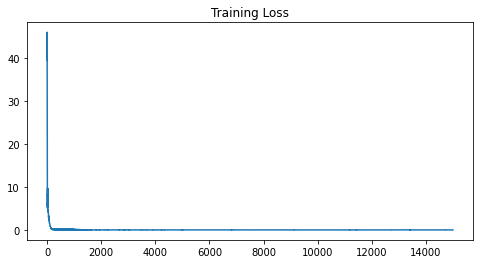

In [ ]:
fig = plt.figure(figsize=(8,4))
plt.plot(training_loss) 
plt.title('Training Loss');

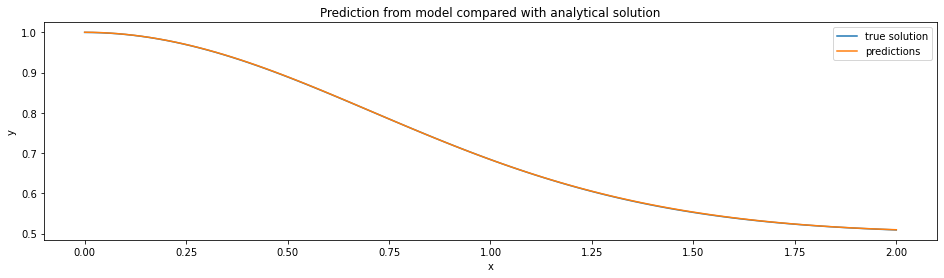

In [ ]:
# test the model 

# Create x test 
x_test = np.linspace(0,2,100).reshape(100,1)
x_test_tensor = tf.convert_to_tensor(x_test)

# load the best weights from training
model.load_weights('best_model')

# get model predictions 
y_pred = model(x_test_tensor)

# analytical solution
y_analytical = 0.5 + 0.5*np.exp(-x_test**2)

# plot 
fig = plt.figure(figsize=(16,4))
plt.plot(x_test, y_analytical, label='true solution')
plt.plot(x_test, y_pred, label='predictions')
plt.title('Prediction from model compared with analytical solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();